In [1]:
%matplotlib inline
import daft
import pymc
import matplotlib.pyplot as plt
import matplotlib as mlp
import numpy as np
import ggplot
import pandas as pd

COLORS = ["#348ABD", "#A60628", "#7A68A6"]

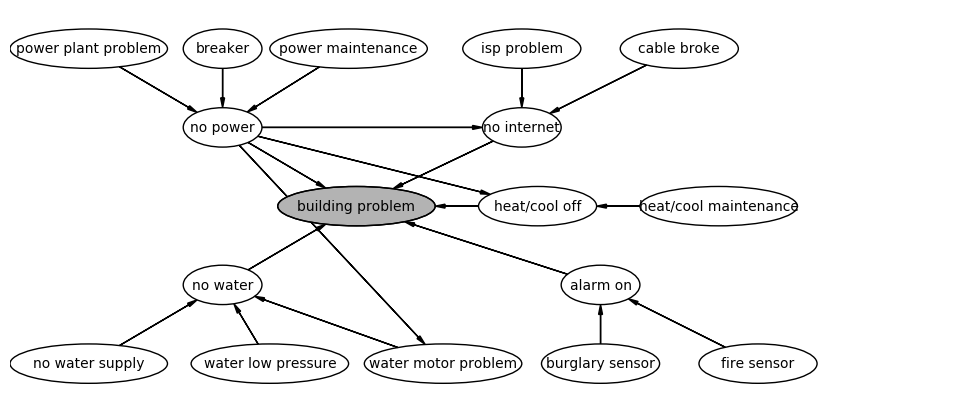

In [2]:
pgm = daft.PGM([12, 5], origin=[1, 0.5])
"""
    17 nodes
"""
pgm.add_node(daft.Node('pm', 'power maintenance', 5.3, 5, aspect=4))
pgm.add_node(daft.Node('br', 'breaker', 3.7, 5, aspect=2))
pgm.add_node(daft.Node('ppp', 'power plant problem', 2, 5, aspect=4))

pgm.add_node(daft.Node('np', 'no power', 3.7, 4, aspect=2))


pgm.add_node(daft.Node('isp', 'isp problem', 7.5, 5, aspect=3))
pgm.add_node(daft.Node('csb', 'cable broke', 9.5, 5, aspect=3))

pgm.add_node(daft.Node('ni', 'no internet', 7.5, 4, aspect=2))


pgm.add_node(daft.Node('hcm', 'heat/cool maintenance', 10, 3, aspect=4))

pgm.add_node(daft.Node('hc', 'heat/cool off', 7.7, 3, aspect=3))


pgm.add_node(daft.Node('bp', 'building problem', 5.4, 3, aspect=4, observed=True))


pgm.add_node(daft.Node('nw', 'no water', 3.7, 2, aspect=2))

pgm.add_node(daft.Node('wm', 'water motor problem', 6.5, 1, aspect=4))
pgm.add_node(daft.Node('wp', 'water low pressure', 4.3, 1, aspect=4))
pgm.add_node(daft.Node('ws', 'no water supply', 2, 1, aspect=4))


pgm.add_node(daft.Node('al', 'alarm on', 8.5, 2, aspect=2))

pgm.add_node(daft.Node('bs', 'burglary sensor', 8.5, 1, aspect=3))
pgm.add_node(daft.Node('fs', 'fire sensor', 10.5, 1, aspect=3))


pgm.add_edge('pm', 'np')
pgm.add_edge('br', 'np')
pgm.add_edge('ppp', 'np')

pgm.add_edge('isp', 'ni')
pgm.add_edge('csb', 'ni')

pgm.add_edge('hcm', 'hc')

pgm.add_edge('wm', 'nw')
pgm.add_edge('wp', 'nw')
pgm.add_edge('ws', 'nw')

pgm.add_edge('bs', 'al')
pgm.add_edge('fs', 'al')


pgm.add_edge('np', 'ni')
pgm.add_edge('np', 'wm')
pgm.add_edge('np', 'hc')

pgm.add_edge('np', 'bp')
pgm.add_edge('ni', 'bp')
pgm.add_edge('hc', 'bp')
pgm.add_edge('nw', 'bp')
pgm.add_edge('al', 'bp')

pgm.render()

In [3]:
# Initialization
observed_values = [1.]

power_plant = pymc.Bernoulli('power_plant', .001, value=np.ones(len(observed_values)))
power_maintenance = pymc.Bernoulli('power_maintenance', .027, value=np.ones(len(observed_values)))
power_breaker = pymc.Bernoulli('power_breaker', .01, value=np.ones(len(observed_values)))

p_nopower = pymc.Lambda('p_nopower', lambda power_breaker=power_breaker, power_maintenance=power_maintenance, power_plant=power_plant: np.where(power_breaker, 
                                                                                                                                                    np.where(power_maintenance,
                                                                                                                                                    np.where(power_plant, 0.99, .9),
                                                                                                                                                    np.where(power_plant, .95, .85)),
                                                                                                                                                    np.where(power_maintenance,
                                                                                                                                                    np.where(power_plant, 0.7, .2),
                                                                                                                                                    np.where(power_plant, 0.6, .01))))
nopower = pymc.Bernoulli('nopower', p_nopower, value=observed_values)

hc_maintenance = pymc.Bernoulli('hc_maintenance', .005, value=np.ones(len(observed_values)))
p_hcoff = pymc.Lambda('p_hcoff', lambda nopower=nopower, hc_maintenance=hc_maintenance: np.where(nopower, np.where(hc_maintenance, 0.9,0.8), np.where(hc_maintenance, 0.1,0.1)))

hcoff = pymc.Bernoulli('hcoff', p_hcoff, value=observed_values)

isp_problem = pymc.Bernoulli('isp_problem', .1, value=np.ones(len(observed_values)))
cable_broke = pymc.Bernoulli('cable_broke', .001, value=np.ones(len(observed_values)))


p_nointernet = pymc.Lambda('p_nointernet', lambda isp_problem=isp_problem, cable_broke=cable_broke, nopower=nopower: np.where(isp_problem, np.where(cable_broke, np.where(nopower, 1, .7), np.where(nopower, .65, .4)), 
                                                                                                                                np.where(cable_broke, np.where(nopower, .8, .6), np.where(nopower, .45, .01))))
nointernet = pymc.Bernoulli('nointernet', p_nointernet, value=observed_values)

fire_sensor = pymc.Bernoulli('fire_sensor', .0001, value=np.ones(len(observed_values)))
burglary_sensor = pymc.Bernoulli('burglary_sensor', .0001, value=np.ones(len(observed_values)))

p_alarmon = pymc.Lambda('p_alarmon', lambda burglary_sensor=burglary_sensor, fire_sensor=fire_sensor: np.where(burglary_sensor, np.where(fire_sensor, .9, .7), 
                                                                                         np.where(fire_sensor, .6, 0.1)))

alarmon = pymc.Bernoulli('alarmon', p_alarmon, value=observed_values)

p_wmproblem = pymc.Lambda('p_wmproblem', lambda nopower=nopower: np.where(nopower, .99, .005))
wm_problem = pymc.Bernoulli('wm_problem', p_wmproblem, value=np.ones(len(observed_values)))

w_lpressure = pymc.Bernoulli('w_lpressure',0.01,value=np.ones(len(observed_values)))
w_nosupply=pymc.Bernoulli('w_nosupply',0.001,value=np.ones(len(observed_values)))

p_nowater = pymc.Lambda('p_nowater', lambda  wm_problem=wm_problem, w_lpressure=w_lpressure,w_nosupply=w_nosupply: np.where(wm_problem,np.where(w_lpressure,np.where(w_nosupply,1,.7),np.where(w_nosupply,.75,.6)),np.where(w_lpressure,np.where(w_nosupply,.65,.3),np.where(w_nosupply,.45,0.01))))

nowater = pymc.Bernoulli('nowater', p_nowater, value=observed_values)
#nopower
#nointernet
#hcoff
#alarmon
#nowater
# 2^ 5 = 32
p_buildingproblem = pymc.Lambda('p_buildingproblem', lambda nopower=nopower, nointernet=nointernet, hcoff=hcoff, alarmon=alarmon, nowater=nowater: np.where(nopower, np.where(nointernet, np.where(hcoff, np.where(alarmon, np.where(nowater, 0.99, 0.92), np.where(nowater, 0.7, 0.62)), np.where(alarmon, np.where(nowater, 0.95, 0.9), np.where(nowater, 0.65, 0.58))), np.where(hcoff, np.where(alarmon, np.where(nowater, 0.93, 0.89), np.where(nowater, 0.63, 0.55)), np.where(alarmon, np.where(nowater, 0.91, 0.87), np.where(nowater, 0.6, 0.5)))), np.where(nointernet, np.where(hcoff, np.where(alarmon, np.where(nowater, 0.88, 0.84), np.where(nowater, 0.4, 0.35)), np.where(alarmon, np.where(nowater, 0.86, 0.82), np.where(nowater, 0.47, 0.25))), np.where(hcoff, np.where(alarmon, np.where(nowater, 0.83, 0.81), np.where(nowater, 0.37, 0.1)), np.where(alarmon, np.where(nowater, 0.85, 0.8), np.where(nowater, 0.3, 0.01))))))

buildingproblem = pymc.Bernoulli('buildingproblem', p_buildingproblem, value=observed_values, observed=True)

# model = pymc.Model([alarmon, p_alarmon, fire_sensor, burglary_sensor])
# model = pymc.Model([nopower, p_nopower, power_plant, power_maintenance,power_breaker])
# model = pymc.Model([hcoff, p_hcoff, hc_maintenance])
# model = pymc.Model([nointernet, cable_broke, isp_problem])
# model = pymc.Model([nowater, wm_problem, w_lpressure, w_nosupply])
model = pymc.Model([buildingproblem, p_buildingproblem, nopower, p_nopower, power_plant, power_breaker, power_maintenance, nowater, p_nowater, wm_problem, p_wmproblem, w_lpressure, w_nosupply, alarmon, p_alarmon, fire_sensor, burglary_sensor, hcoff, p_hcoff, hc_maintenance, nointernet, p_nointernet, isp_problem, cable_broke ])


graph = pymc.graph.graph(model)
graph.write_png("graph.png")

True

In [4]:
## Inference
mcmc = pymc.MCMC(model)
mcmc.sample(500000, 1000, 100)

 [-----------------100%-----------------] 500000 of 500000 complete in 458.2 sec

In [6]:
trace_pp = mcmc.trace('power_plant')[:]
trace_pb = mcmc.trace('power_breaker')[:]
trace_pm = mcmc.trace('power_maintenance')[:]
trace_nopower = mcmc.trace('nopower')[:]

trace_hcm = mcmc.trace('hc_maintenance')[:]
trace_hco = mcmc.trace('p_hcoff')[:]
trace_hc = mcmc.trace('hcoff')[:]

trace_cb = mcmc.trace('cable_broke')[:]
trace_isp = mcmc.trace('isp_problem')[:]
trace_ni = mcmc.trace('nointernet')[:]

trace_fs = mcmc.trace('fire_sensor')[:]
trace_bs = mcmc.trace('burglary_sensor')[:]
trace_ao = mcmc.trace('alarmon')[:]

trace_wmp = mcmc.trace('wm_problem')[:]
trace_wlp = mcmc.trace('w_lpressure')[:]
trace_wns = mcmc.trace('w_nosupply')[:]
trace_nw = mcmc.trace('nowater')[:]

trace_p_bp = mcmc.trace('p_buildingproblem')[:]

Plotting cable_broke_0
Plotting power_breaker_0
Plotting power_maintenance_0
Plotting p_nointernet_0
Plotting w_lpressure_0
Plotting nointernet_0
Plotting power_plant_0
Plotting p_buildingproblem_0
Plotting fire_sensor_0
Plotting p_nopower_0
Plotting burglary_sensor_0
Plotting p_wmproblem_0
Plotting nopower_0
Plotting wm_problem_0
Plotting hc_maintenance_0
Plotting nowater_0
Plotting alarmon_0
Plotting p_alarmon_0
Plotting w_nosupply_0
Plotting p_hcoff_0
Plotting hcoff_0


/home/isamel/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Plotting p_nowater_0
Plotting isp_problem_0


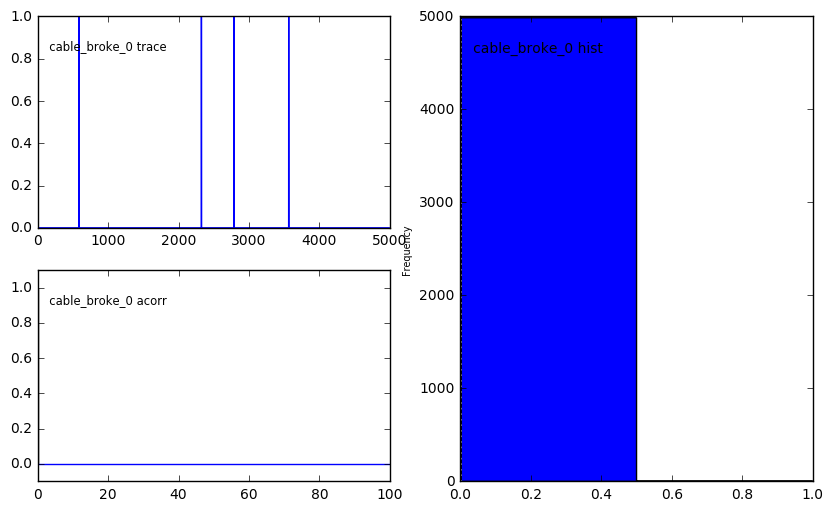

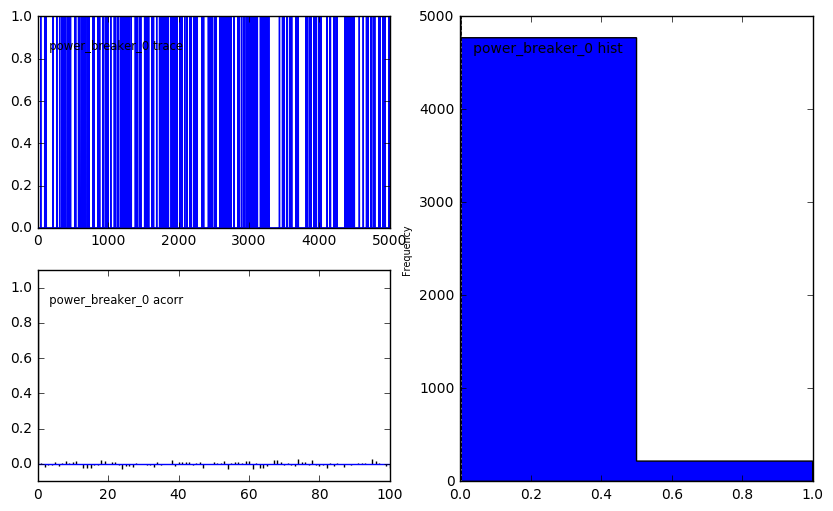

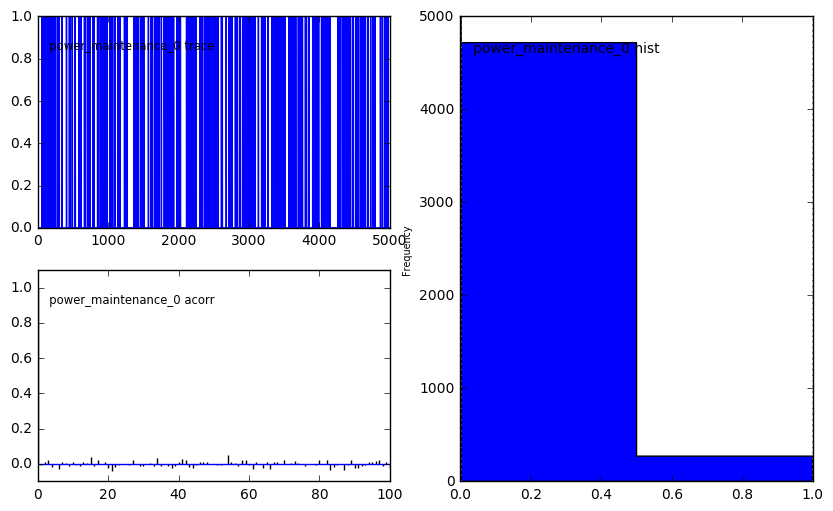

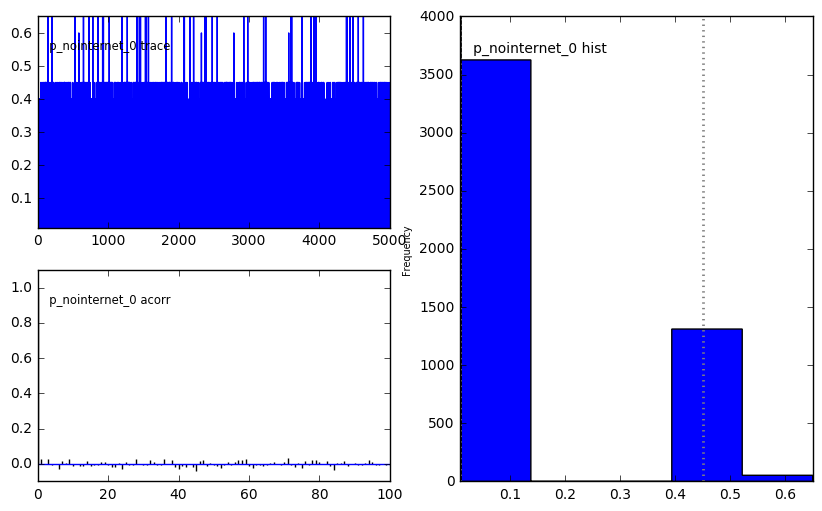

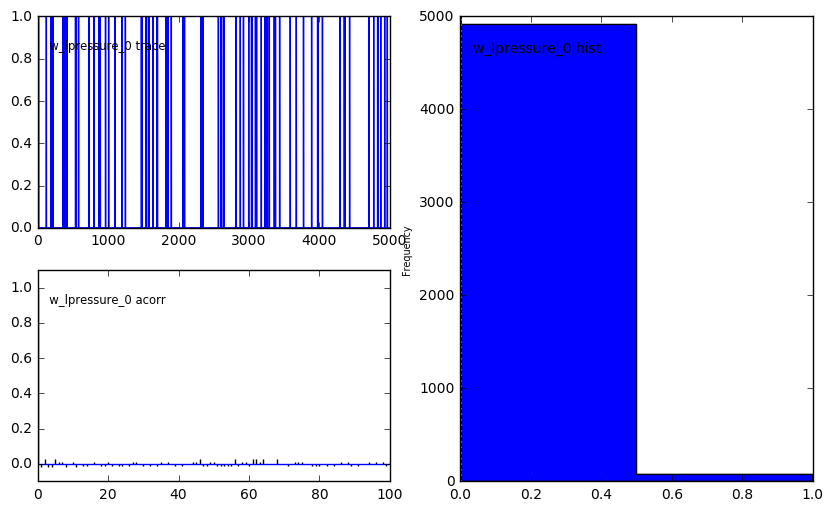

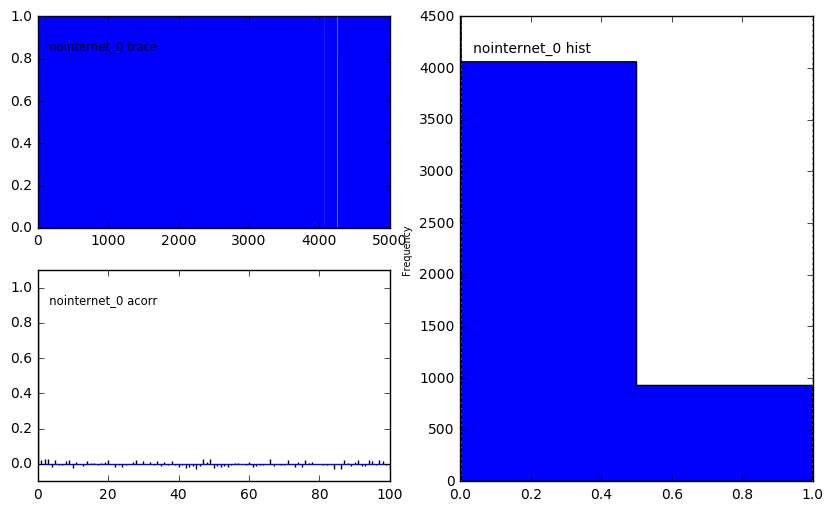

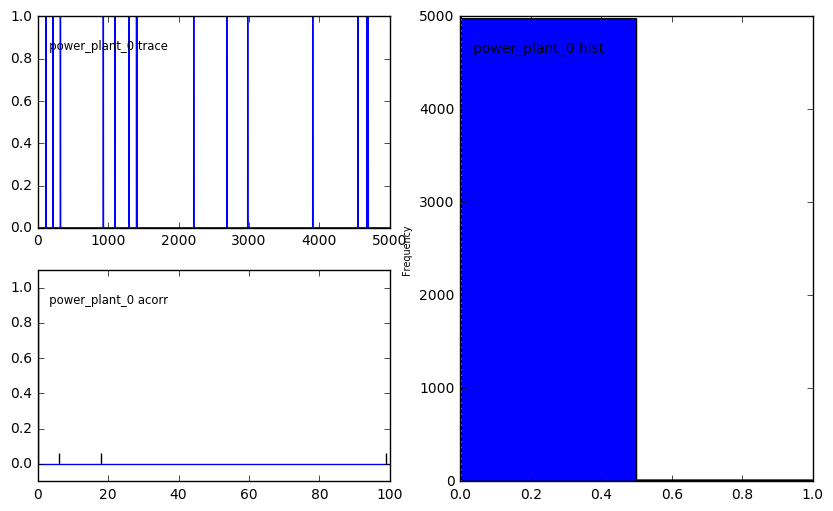

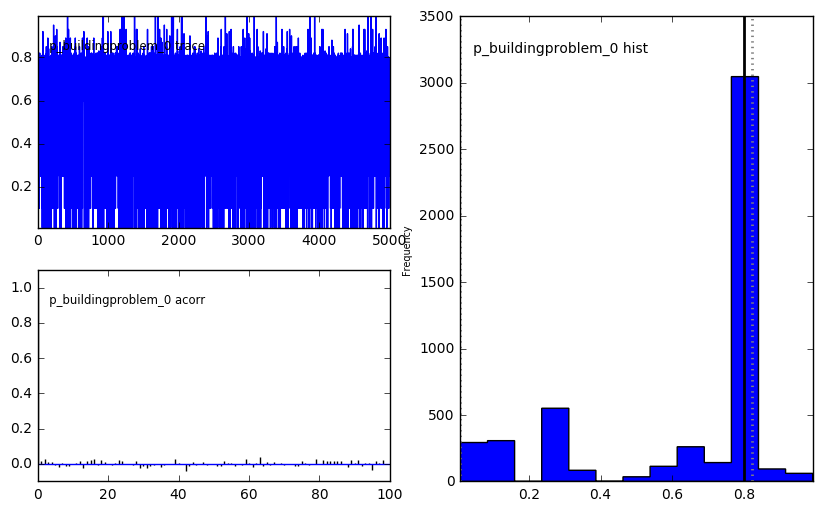

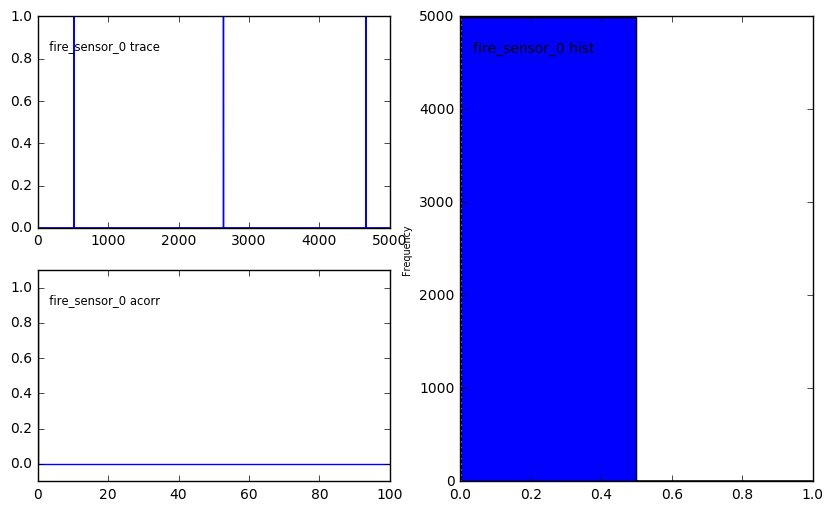

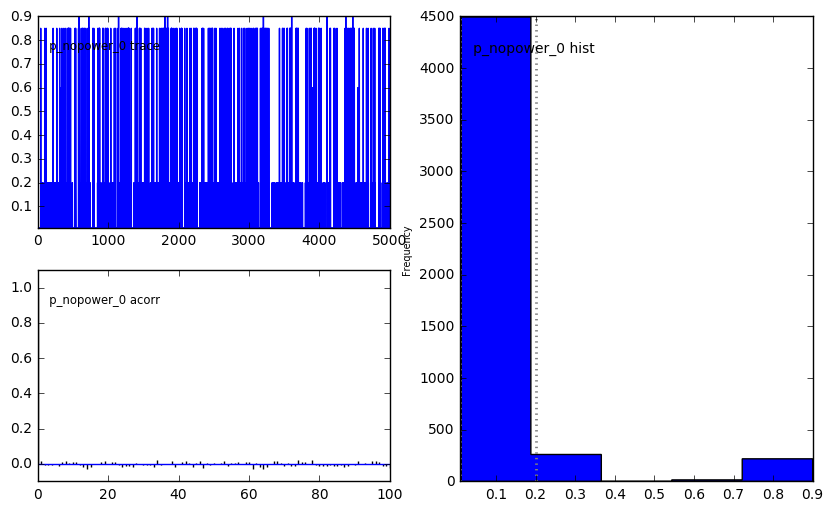

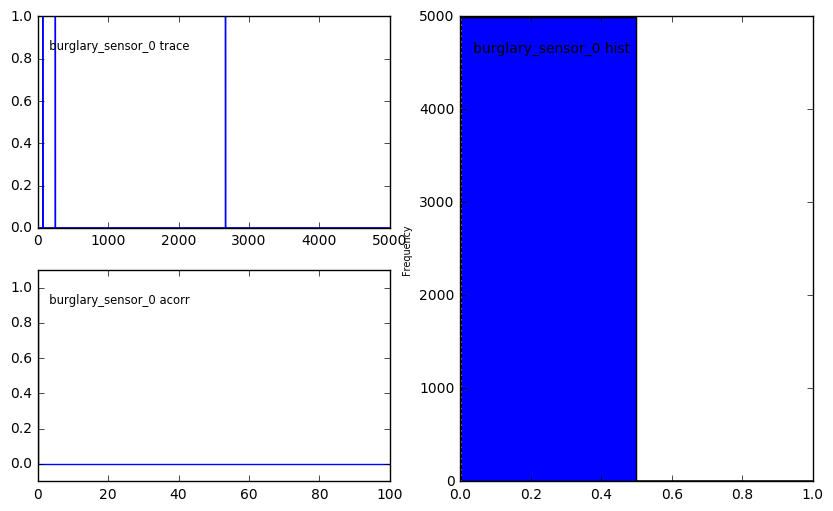

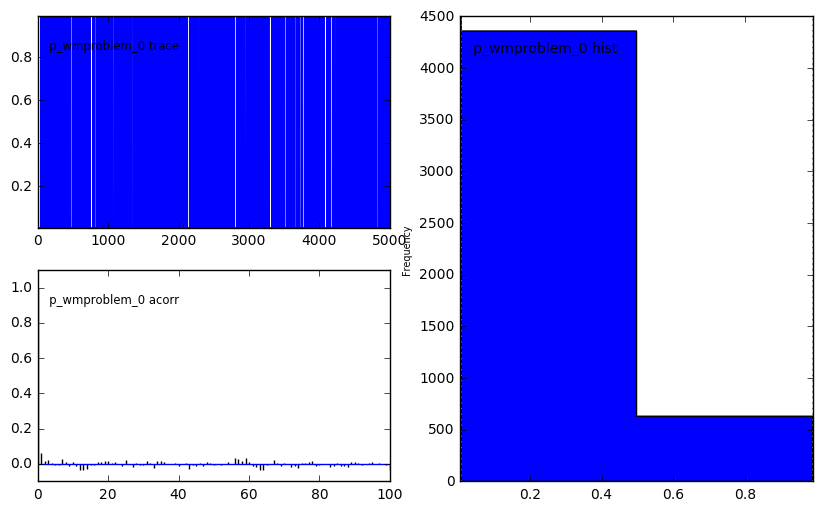

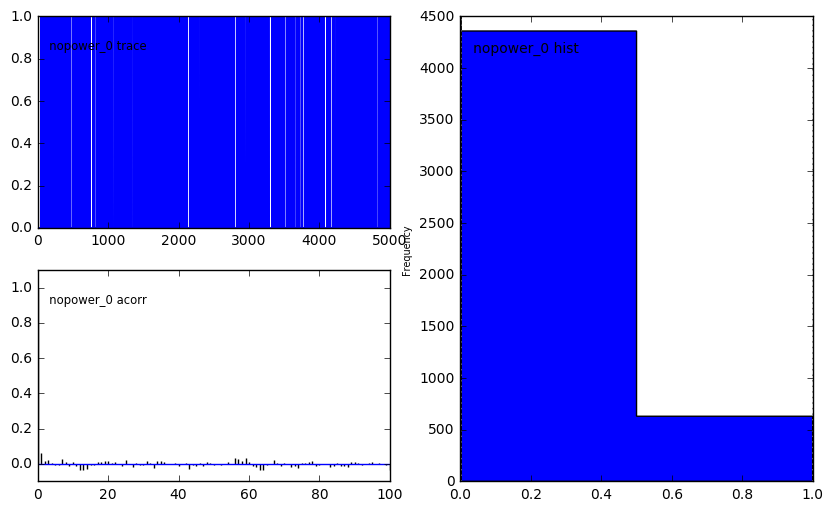

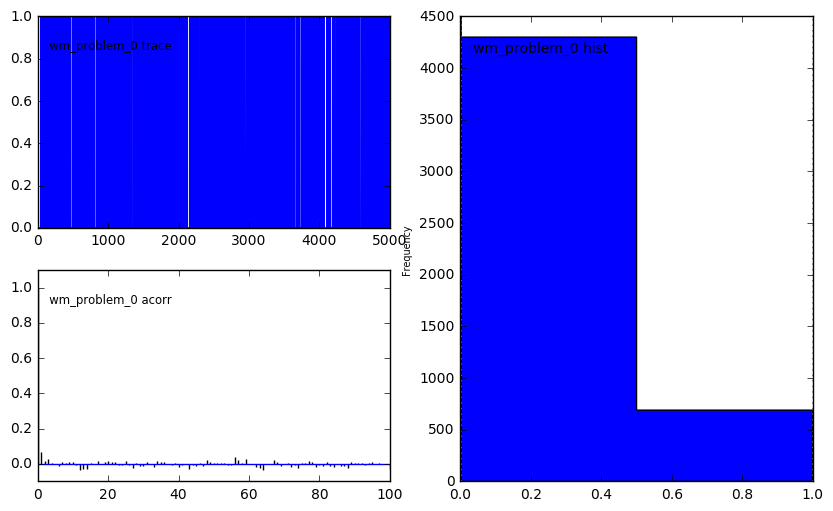

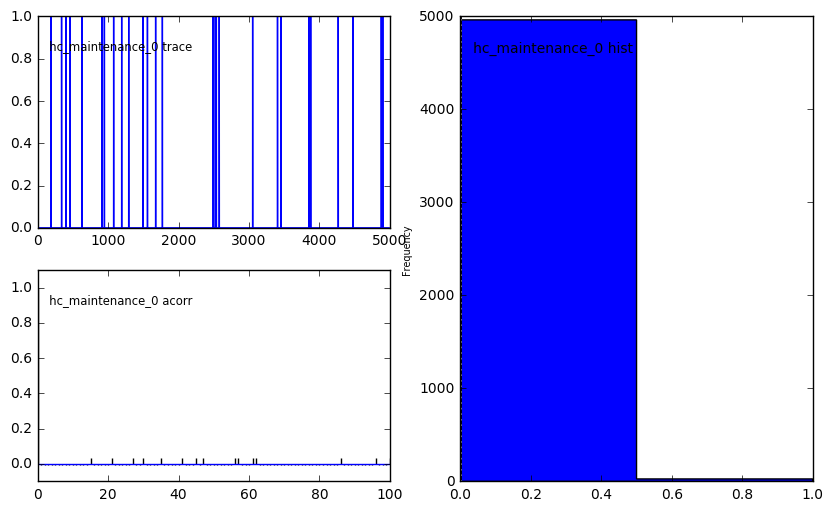

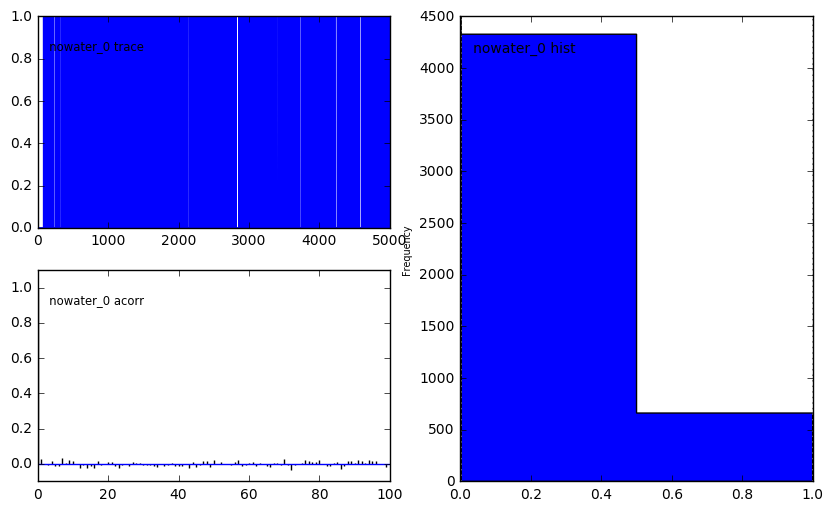

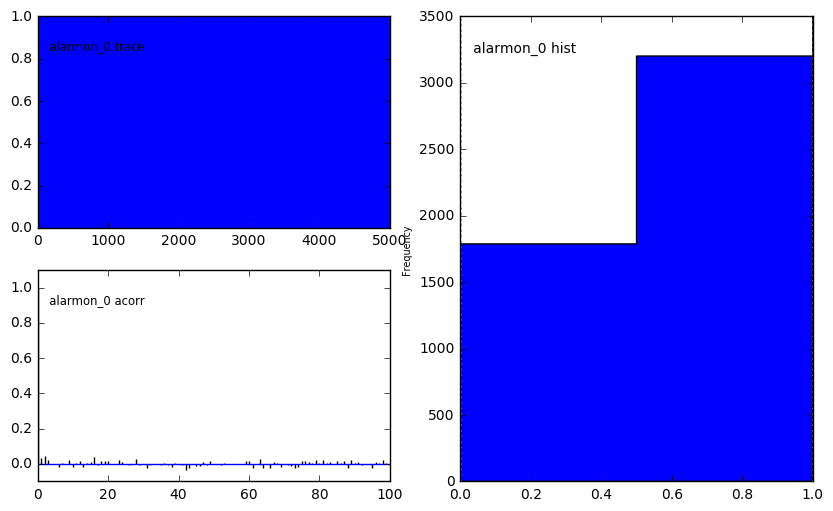

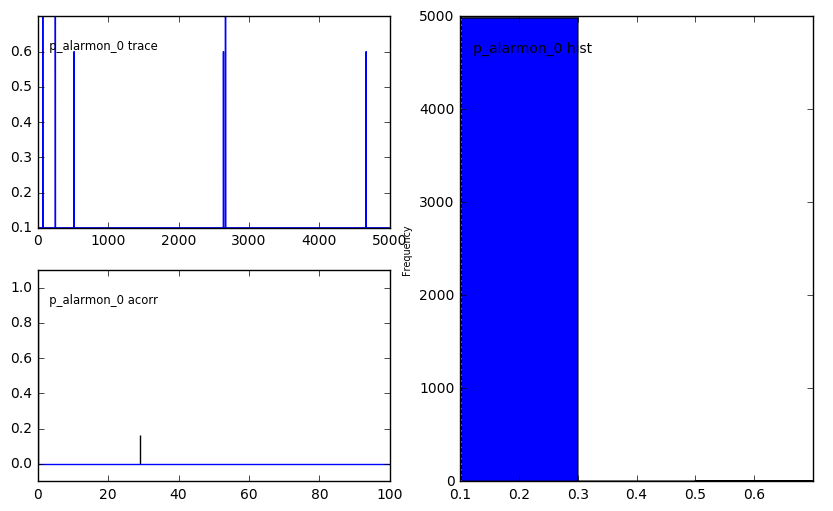

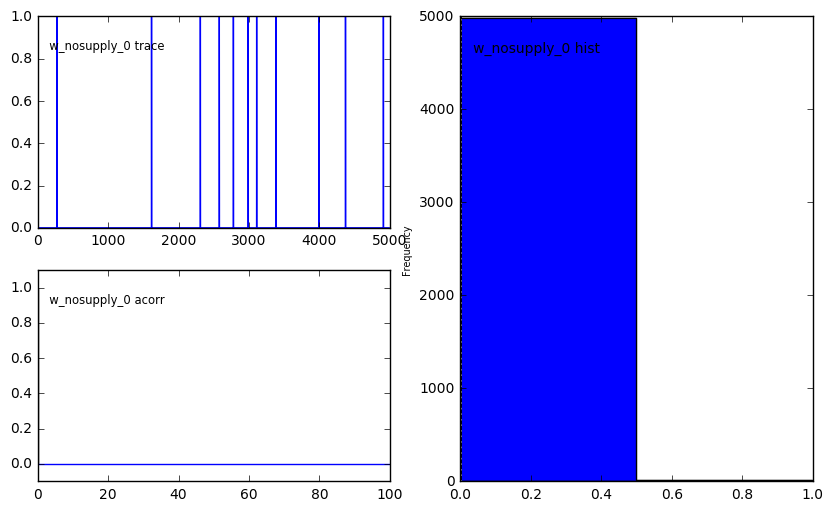

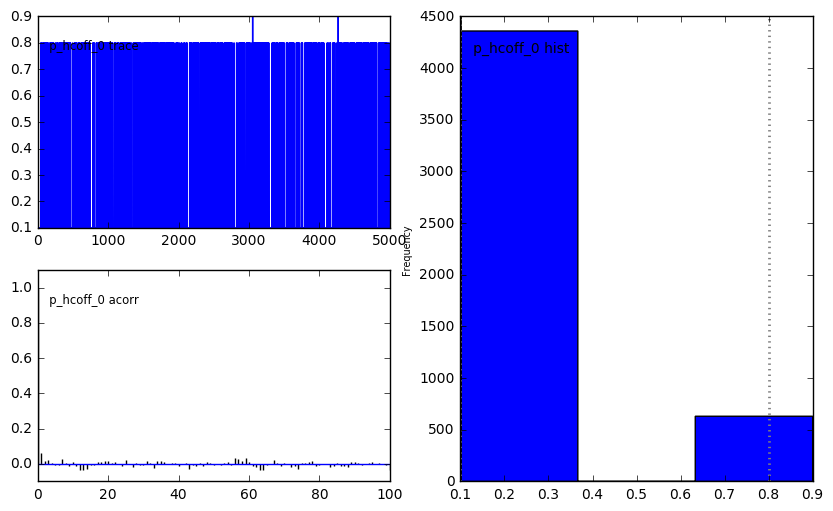

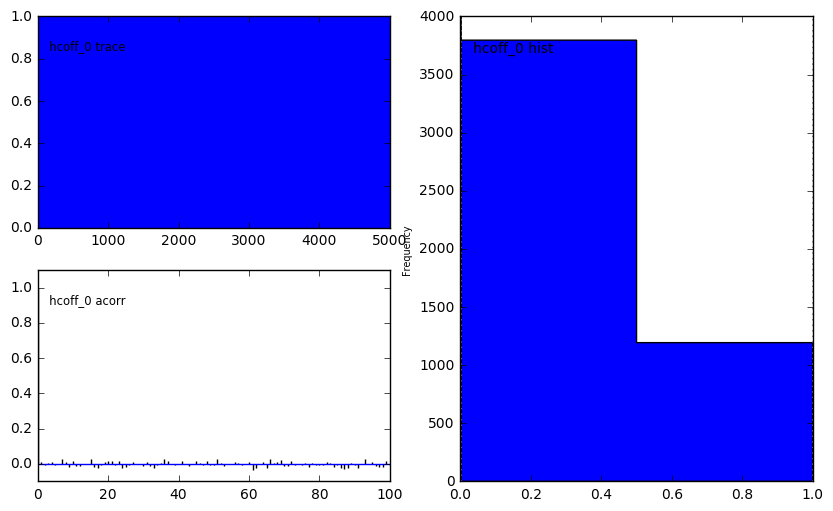

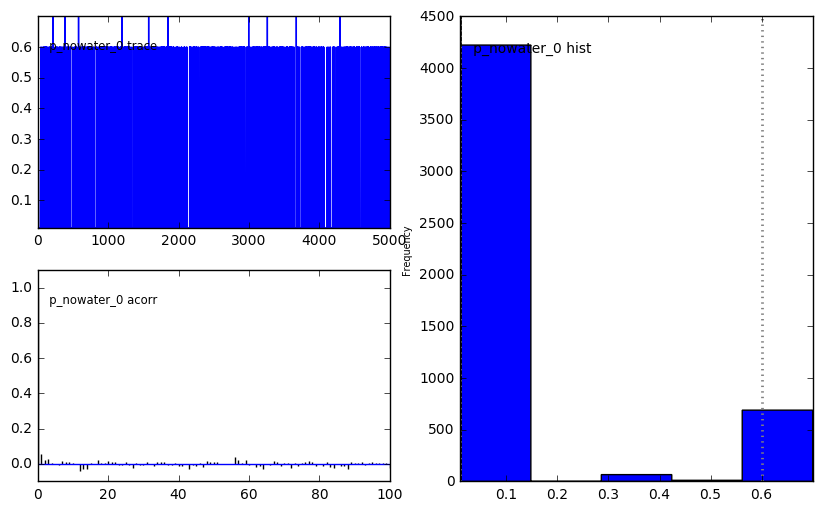

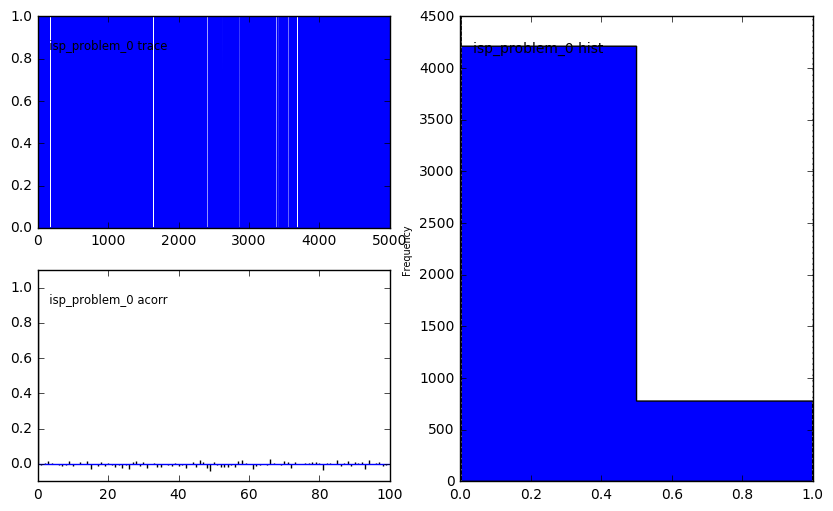

In [7]:
# Convergence diagnostic
pymc.Matplot.plot(mcmc)

In [9]:
print len(trace_nopower.tolist())
print len(trace_hc.tolist())
print len(trace_ni.tolist())
print len(trace_ao.tolist())
print len(trace_nw.tolist())
print len(trace_p_bp.tolist())
    
dictionary = {
              'No Power': [1 if ii[0] else 0 for ii in trace_nopower.tolist() ],
              'H/C Off': [1 if ii[0] else 0 for ii in trace_hc.tolist() ],
              'No Internet': [1 if ii[0] else 0 for ii in trace_ni.tolist() ],
              'Alarm went On': [1 if ii[0] else 0 for ii in trace_ao.tolist() ],
              'No Water': [1 if ii[0] else 0 for ii in trace_nw.tolist() ],
              'Building Problem': [ii[0] for ii in trace_p_bp.tolist()],
              }
df = pd.DataFrame(dictionary)
print df
df.head()


4990
4990
4990
4990
4990
4990
      Alarm went On  Building Problem  H/C Off  No Internet  No Power  \
0                 1              0.80        0            0         0   
1                 1              0.81        1            0         0   
2                 1              0.80        0            0         0   
3                 1              0.80        0            0         0   
4                 0              0.01        0            0         0   
5                 1              0.80        0            0         0   
6                 1              0.80        0            0         0   
7                 0              0.10        1            0         0   
8                 1              0.80        0            0         0   
9                 1              0.80        0            0         0   
10                1              0.80        0            0         0   
11                1              0.80        0            0         0   
12                1  

,Alarm went On,Building Problem,H/C Off,No Internet,No Power,No Water
0,1,0.80,0,0,0,0
1,1,0.81,1,0,0,0
2,1,0.80,0,0,0,0
3,1,0.80,0,0,0,0
4,0,0.01,0,0,0,0


In [29]:
# Given there is a building problem, what is the probability that the alarm is turned on?
p_alarmon_buildingproblem = float(df[(df['Alarm went On'] == 1) & (df['Building Problem'] > 0.7)].shape[0]) / df[df['Building Problem'] > 0.7].shape[0] 
print(p_alarmon_buildingproblem)

1.0


In [13]:
# Given there is a building problem, what is the probability that there is no power?
p_nopower_buildingproblem = float(df[(df['No Power'] == 1) & (df['Building Problem'] > 0.7)].shape[0]) / df[df['Building Problem'] > 0.7].shape[0] 
print(p_nopower_buildingproblem)

0.0276705276705


In [14]:
# Given there is a building problem, what is the probability that there is no internet?
p_nointernet = float(df[(df['No Internet'] == 1) & (df['Building Problem'] > 0.7)].shape[0]) / df[df['Building Problem'] > 0.7].shape[0] 
print(p_nointernet)

0.0598455598456


In [15]:
# Given there is a building problem, what is the probability that there is no water?
p_nowater = float(df[(df['No Water'] == 1) & (df['Building Problem'] > 0.7)].shape[0]) / df[df['Building Problem'] > 0.7].shape[0] 
print(p_nowater)

0.0289575289575


In [16]:
# Given there is a building problem, what is the probability that there is no water?
p_hcoff = float(df[(df['H/C Off'] == 1) & (df['Building Problem'] > 0.5)].shape[0]) / df[df['Building Problem'] > 0.5].shape[0] 
print(p_hcoff)

0.225508819539


In [17]:
# Given there is a building problem, what is the probability that the there is no power and all other ?
p_hcoff = float(df[(df['H/C Off'] == 0) & (df['No Internet'] == 0) & (df['No Water'] == 0) & (df['No Power'] == 1) & (df['Alarm went On'] == 0) & (df['Building Problem'] > 0.5)].shape[0]) / df[df['Building Problem'] > 0.5].shape[0] 
print(p_hcoff)

0.0


In [31]:
#P(Alarm+|All Systems not working working, Building Problem 70% true)
Variable_stateAp = df[(df['Alarm went On']==1) & (df['No Power']==1) & (df['No Internet']==1) & (df['H/C Off']==1) 
                 & (df['No Water']==1) & (df['Building Problem'] > 0.7)].shape[0]
Observed_StatesAp = float(df[(df['No Power']==1) & (df['No Internet']==1) & (df['H/C Off']==1) & (df['No Water']==1) 
                    & (df['Building Problem'] > 0.7)].shape[0])
PA_alarm = Variable_stateAp/Observed_StatesAp 

#P(Alarm-|All systems working, Building Problem 70% true)
Variable_stateAm = df[(df['Alarm went On']==0) & (df['No Power']==1) & (df['No Internet']==1) & (df['H/C Off']==1) 
                 & (df['No Water']==1) & (df['Building Problem'] > 0.7)].shape[0]
Observed_StatesAm = float(df[(df['No Power']==1) & (df['No Internet']==1) & (df['H/C Off']==1) & (df['No Water']==1) 
                    & (df['Building Problem'] > 0.7)].shape[0])
P_Nalarm = Variable_stateAm/Observed_StatesAm 

#P(Heating+|All Systems not working working, Building Problem 70% true)
Variable_stateHp= df[(df['Alarm went On']==1) & (df['No Power']==1) & (df['No Internet']==1) & (df['H/C Off']==1) 
                 & (df['No Water']==1) & (df['Building Problem'] > 0.7)].shape[0]
Observed_StatesHp = float(df[(df['No Power']==1) & (df['No Internet']==1) & (df['Alarm went On']==1) & (df['No Water']==1) 
                    & (df['Building Problem'] > 0.7)].shape[0])
P_Heatingp = Variable_stateHp/Observed_StatesHp 

#P(Heating-|All systems working, Building Problem 70% true)
Variable_stateHn = df[(df['Alarm went On']==1) & (df['No Power']==1) & (df['No Internet']==1) & (df['H/C Off']==0) 
                 & (df['No Water']==1) & (df['Building Problem'] > 0.7)].shape[0]
Observed_StatesHn = float(df[(df['No Power']==1) & (df['No Internet']==1) & (df['Alarm went On']==1) & (df['No Water']==1) 
                    & (df['Building Problem'] > 0.7)].shape[0])
P_Heatingn = Variable_stateHn/Observed_StatesHn 

#P(Internet+|All Systems not working working, Building Problem 70% true)
Variable_stateIp = df[(df['Alarm went On']==1) & (df['No Power']==1) & (df['No Internet']==1) & (df['H/C Off']==1) 
                 & (df['No Water']==1) & (df['Building Problem'] > 0.7)].shape[0]
Observed_StatesIp = float(df[(df['No Power']==1) & (df['H/C Off']==1) & (df['Alarm went On']==1) 
                    & (df['No Water']==1) & (df['Building Problem'] > 0.7)].shape[0])
P_Heatingp = Variable_stateIp/Observed_StatesIp 

#P(Internet-|All systems working, Building Problem 70% true)
Variable_stateIn = df[(df['Alarm went On']==1) & (df['No Power']==1) & (df['No Internet']==1) & (df['H/C Off']==0) 
                 & (df['No Water']==1) & (df['Building Problem'] > 0.7)].shape[0]
Observed_StatesIn = float(df[(df['No Power']==1) & (df['H/C Off']==1) & (df['Alarm went On']==1) 
                    & (df['No Water']==1) & (df['Building Problem'] > 0.7)].shape[0])
P_Heatingn = Variable_stateIn/Observed_StatesIn 

# Given there is internet and no power what is the probability for the building to have a problem
p_hcoff = float(df[(df['No Internet'] == 0) & (df['No Power'] == 1) & (df['Building Problem'] > 0.5)].shape[0]) / df[(df['No Internet'] == 0) & (df['No Power'] == 1)].shape[0] 
print(p_hcoff)

print('Probability of the Alarm being active and all systems not working when the building has some problem '+ str('{:.1%}'.format(PA_alarm)))
print('Probability of the Alarm being off while all systems are not working when the building has some problem '+ str('{:.1%}'.format(P_Nalarm)))
print('Probability of Heating And Cooling Systems offline and all systems not working when the building has some problem '+ str('{:.1%}'.format(P_Heatingp)))
print('Probability of the Heating And Cooling Systems working and all systems not working when the building has some problem '+ str('{:.1%}'.format(P_Heatingn)))
print('Probability of the Internet not working and all systems not working too when the building has some problem '+ str('{:.1%}'.format(P_Heatingp)))
print('Probability of the Internet Working and all systems not working when the building has some problem '+ str('{:.1%}'.format(P_Heatingn)))

0.940217391304
Probability of the Alarm being active and all systems not working when the building has some problem 100.0%
Probability of the Alarm being off while all systems are not working when the building has some problem 0.0%
Probability of Heating And Cooling Systems offline and all systems not working when the building has some problem 47.7%
Probability of the Heating And Cooling Systems working and all systems not working when the building has some problem 9.1%
Probability of the Internet not working and all systems not working too when the building has some problem 47.7%
Probability of the Internet Working and all systems not working when the building has some problem 9.1%
